In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import warnings
import numpy as np
from collections import defaultdict
from operator import itemgetter
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
import keras
import seaborn as sns; sns.set()

from utils import f1, text_to_wordlist, user_id, sentiment_transform, clean_reaction, sub_user, encoder_predict, user_dict, channel_mapping, process_pred_specified_models


warnings.filterwarnings("ignore")


# main message store
with open('input_data/dan_bot_messages.pkl', 'rb') as f:
    message_list = pickle.load(f)
print(message_list[:2])

/Users/justinfisher/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/justinfisher/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/justinfisher/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/justinfisher/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to 

[{'type': 'message', 'channel': 'C4M8HSESW', 'message': {'client_msg_id': '883715dc-5f24-499e-8deb-99c3eb701064', 'type': 'message', 'text': 'It uses machine learning', 'user': 'U0ZHLNH8E', 'ts': '1551458065.019600', 'thread_ts': '1551457810.017600', 'parent_user_id': 'U55FVUW85', 'permalink': 'https://intellection.slack.com/archives/C4M8HSESW/p1551458065019600?thread_ts=1551457810017600', 'reactions': [{'name': 'facepalm', 'users': ['UGFA5639S'], 'count': 1}, {'name': 'good', 'users': ['UGFA5639S', 'U0L26L3FE'], 'count': 2}]}}, {'type': 'message', 'channel': 'CD7EQ0DAT', 'message': {'client_msg_id': '1eec4f5b-b730-4cc0-9280-523de1d5062b', 'type': 'message', 'text': '<@U8MPPNJRL> _this_ is the kind of whitespace thinking we need here in <#CD7EQ0DAT|ratemyemoji>', 'user': 'U15JXQN4T', 'ts': '1551457518.005900', 'permalink': 'https://intellection.slack.com/archives/CD7EQ0DAT/p1551457518005900', 'reactions': [{'name': '100', 'users': ['U0L26L3FE'], 'count': 1}, {'name': 'ok_hand', 'users'

In [2]:
store = {}
emoji_count = defaultdict(int)

for msg in message_list:
    try:
        if 'message' in msg:
            msg_type, msg_info, channel = itemgetter('type', 'message', 'channel')(msg)
            msg_info_type, msg_text, msg_reactions, msg_time = itemgetter('type', 'text', 'reactions', 'ts')(msg['message'])
            if 'message' in msg and msg_text.strip != '':
                msg_text = sub_user(msg_text)
                clean_msg = text_to_wordlist(msg_text)
                store[clean_msg] = {}
                store[clean_msg]['reactions'] = [clean_reaction(reaction['name']) for reaction in msg_reactions if user_id in reaction['users'] ]
                store[clean_msg]['time'] = msg_time
                store[clean_msg]['type'] = 'message'
                store[clean_msg]['joined_reactions'] = '|'.join(store[clean_msg]['reactions'])
                store[clean_msg]['channel'] = channel
                store[clean_msg]['type'] = msg['type']
                if 'user' in msg['message']:
                    store[clean_msg]['user'] = msg['message']['user']
                elif 'bot_id' in msg['message']:
                    store[clean_msg]['user'] = msg['message']['bot_id']
                for emoji in store[clean_msg]:
                    emoji_count[emoji] += 1
        elif 'file' in msg:
            continue
    except Exception as e:
        print(e)

long_store = []
for k, v in store.items():
    for reaction in v['reactions']:
        long_store.append(
            {'comment': k,
             'emoji': reaction, 
             'channel': channel_mapping.get(v['channel'], 'private'), 
             'time': float(v['time']),
             'user': user_dict.get(v.get('user', 'None'), 'bot'),
             'type': v['type']
            }
        )
        
long_data = pd.DataFrame(long_store)
long_data['time'] =  pd.to_datetime(long_data['time'],unit='s')
long_data = long_data[long_data['time'].dt.year > 2016]

print(long_data.shape)
long_data.tail()

(7837, 6)


,channel,comment,emoji,time,type,user
7832,private,< ! here here rocket kwp production,scream,2017-03-08 09:34:16.771568060,message,jhofmeyr
7833,client-delivery,i still have the theory that we would all be m...,trophy,2017-03-08 09:07:12.560416937,message,helen
7834,client-delivery,i still have the theory that we would all be m...,true_story,2017-03-08 09:07:12.560416937,message,helen
7835,client-delivery,i still have the theory that we would all be m...,heart_eyes,2017-03-08 09:07:12.560416937,message,helen
7836,client-delivery,i still have the theory that we would all be m...,+1,2017-03-08 09:07:12.560416937,message,helen


In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

w=widgets.Dropdown(
    options=long_data['channel'].unique().tolist() + ['all'],
    value='all',
    description='Channel:',
    disabled=False,
)

def my_plot(w):
    fig, ax = plt.subplots(figsize=(12, 7))
    tmp = long_data if w == 'all' else long_data[long_data['channel'] == w]
    tmp.groupby('emoji').count()['time'].rename('count').sort_values(ascending=False).head(35).plot(grid=True, ax=ax, kind='bar');
    ax.set_title('Emoji counts for channel: %s' % w);
    plt.show()

interactive_plot = interactive(my_plot, w=w)
interactive_plot

A Jupyter Widget

In [6]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

w=widgets.Dropdown(
    options=long_data['emoji'].unique().tolist() + ['all'],
    value='all',
    description='Emoji:',
    disabled=False,
)

def my_plot(w):
    fig, ax = plt.subplots(figsize=(12, 8))
    tmp = long_data if w == 'all' else long_data[long_data['emoji'] == w]
    tmp.groupby(pd.Grouper(key='time', freq='M')).count()['emoji'].rolling(2).mean().plot(grid=True, color = 'b');
    ax.set_title('Emoji Count Over Time');
    plt.show()

interactive_plot = interactive(my_plot, w=w)
interactive_plot


A Jupyter Widget

In [7]:
agg = long_data.groupby('emoji').count()['comment']

emoji_counts = pd.DataFrame(agg.sort_values(ascending=False))
filtered_emojis = emoji_counts[emoji_counts['comment'] > 20].index.tolist() + ['elephant']
df = long_data[long_data['emoji'].isin(filtered_emojis)]
print('filering comments with most commonn emojis, down to ', df.shape)
filtered_emojis[:20]

filering comments with most commonn emojis, down to  (5343, 6)


['joy',
 '+1',
 'true_story',
 'fire',
 'notsureif',
 'squanchy',
 'amasin',
 'point_up',
 'trophy',
 '100',
 'facepalm',
 'wow',
 'eggplant',
 'heart',
 'ok_hand',
 'wat',
 'good',
 'trollface',
 'raised_hands',
 'omar']

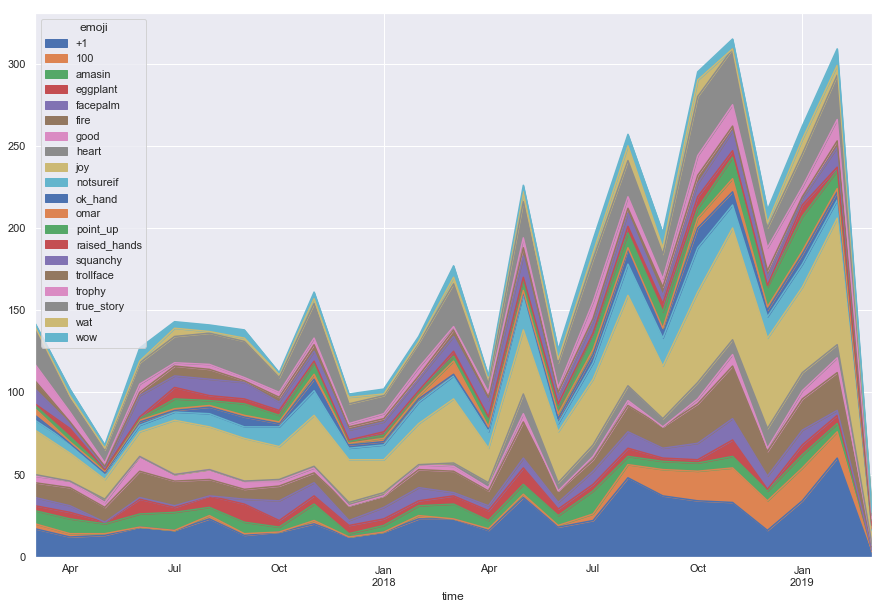

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
subset_emojis = long_data[long_data['emoji'].isin(filtered_emojis[:20])]
subset_emojis.groupby([pd.Grouper(key='time', freq='M'), 'emoji']).count()['channel'].unstack().fillna(0).plot.area(ax=ax);

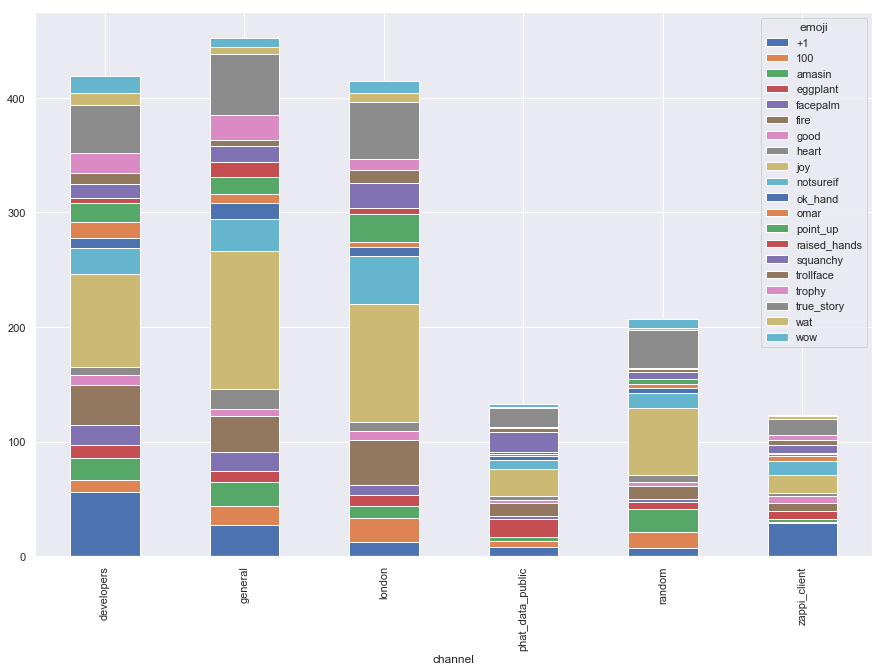

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
subset_emojis[subset_emojis['channel'].isin([
    'general', 'london', 'phat_data_public', 
    'zappi_client', 'random', 'developers'
])].groupby(['channel', 'emoji']).count()['type'].unstack().plot(kind='bar', stacked=True, ax=ax);

In [10]:
formatted_table = pd.get_dummies(df, columns = ['emoji']).groupby(['comment', 'time', 'channel', 'type', 'user'], sort=False, as_index=False).max()
print(formatted_table.shape)
formatted_table.head()

(4580, 65)


,comment,time,channel,type,user,emoji_+1,emoji_100,emoji_amasin,emoji_brendan,emoji_burrito,...,emoji_trollface,emoji_trophy,emoji_true_story,emoji_trump,emoji_wat,emoji_watchout_badass,emoji_whip,emoji_white_check_mark,emoji_wow,emoji_wow_savage
0,it uses machine learning,2019-03-01 16:34:25.019599915,phat_data_public,message,richardf,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tanner this is the kind of whitespace thinki...,2019-03-01 16:25:18.005899906,ratemyemoji,message,Cal,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ok so we can now just invite danbot back and w...,2019-03-01 15:47:19.125900030,developers,message,tommy,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,i think that it will mean that we will only fi...,2019-03-01 15:35:54.017600060,quality_initiative,message,herman,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,what do you guys think about disabling sentrie...,2019-03-01 15:34:00.015700102,quality_initiative,message,tomskopek,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [13]:
max_words = 10000

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df[df['tfidf'] > 0]

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

# TF IDF
vectorizer = TfidfVectorizer(max_features = max_words)
comment_vectors = vectorizer.fit_transform(formatted_table.comment.tolist())
features = vectorizer.get_feature_names()


row_id =1005
table_slice = formatted_table.iloc[row_id]

print(table_slice[['comment', 'channel', 'user']])
print('')
print(table_slice[table_slice == 1])
print('')
print(vectorizer.inverse_transform(comment_vectors[row_id]))
top_feats_in_doc(comment_vectors, features, row_id)

comment    all is loading fine again 
channel         tech_critical_updates
user                     joaoquaresma
Name: 1005, dtype: object

emoji_raised_hands    1
Name: 1005, dtype: object

[array(['is', 'all', 'again', 'fine', 'loading'], dtype='<U64')]


,feature,tfidf
0,loading,0.639957
1,fine,0.477036
2,again,0.452874
3,all,0.325202
4,is,0.228126


In [7]:
# Sentiment feature
sentiment = np.array(list(formatted_table.comment.apply(sentiment_transform).values))

# Channel feature
channel_encoder = LabelBinarizer()
one_hot_channels = channel_encoder.fit_transform(formatted_table['channel'].values.reshape(-1, 1))

# User feature
user_encoder = LabelBinarizer()
one_hot_users = user_encoder.fit_transform(formatted_table['user'].values.reshape(-1, 1))

In [8]:
# Concat features & split train/test
X = np.concatenate((comment_vectors.toarray(), sentiment, one_hot_channels, one_hot_users), axis=1)
y_cols = [i for i in formatted_table.columns if 'emoji' in i]
Y = formatted_table[y_cols]

print(X.shape, Y.shape)


Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=1000)
print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(4505, 8724) (4505, 61)
(3604, 8724) (3604, 61)
(901, 8724) (901, 61)


In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.optimizers import SGD
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(Xtrain.shape[1],)))
model.add(Dropout(0.3))
model.add(Dense(Ytrain.shape[1]))
model.add(Activation('sigmoid'))

print(model.summary())
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1, categorical_accuracy])

batch_size = 32
epochs = 25

early_stopping = EarlyStopping(patience=3)
history = model.fit(Xtrain, Ytrain, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(Xtest, Ytest), 
#                     callbacks=[early_stopping]
                   )
score = model.evaluate(Xtest, Ytest, batch_size=batch_size, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test F1', score[2])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               4467200   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 61)                31293     
_________________________________________________________________
activation_1 (Activation)    (None, 61)                0         
Total params: 4,498,493
Trainable params: 4,498,493
Non-trainable params: 0
_________________________________________________________________
None
Train on 3604 samples, validate on 901 samples
Epoch 1/25
3604/3604 [==============================] - 9s 3ms/step - loss: 0.2123 - f1: 0.0025 - categorical_accuracy: 0.1068 - val_loss: 0.0818 - val_f1: 0.0000e+00 - val_categorical_accuracy: 0.1731
Epoch 2/25

In [10]:

def process_pred(sentence, channel, user):
    return process_pred_specified_models(
        sentence,
        channel,
        user,
        vectorizer,
        channel_encoder,
        user_encoder,
        y_cols
    )
test_sentences = [
    'brexit makes me sad',
    'great job on getting autocoding out, you massive nerds',
    'on leave that week', 
    'production is down', 
    'just be better', 
    'work harder', 
    'rocket to production', 
    'thats just wrong',
    'windows over mac',
    'you are a bell end',
    "it's not unreasonable to have a w9am meeting",
    "My understanding from talking to different folks is the issue is due to the different text length",
    '@steven.perianen IBM is loving the new verbatim auto coding!',
    'heyhey @daniel.baark -> https://zigroup.atlassian.net/browse/SP-5320',
    "The new DS review time clashes with another meeting",
    "It's not like me to skip meals",
    "There has been a complaint about people using the putney office and keeping the door propped open. Can people make sure the door isn't kept open when it shouldn't be.",
    "Ahh we call them a Microsoft Product Team"
]

for i, sent in enumerate(test_sentences):
    print(sent, '->', process_pred(sent, 'phat_data_public', 'fish'))

brexit makes me sad -> ['joy']
great job on getting autocoding out, you massive nerds -> ['facepalm', 'joy']
on leave that week -> []
production is down -> ['notsureif', 'true_story']
just be better -> ['true_story']
work harder -> ['eggplant', 'joy', 'squanchy']
rocket to production -> ['ok_hand']
thats just wrong -> ['facepalm', 'joy']
windows over mac -> ['true_story']
you are a bell end -> ['fire']
it's not unreasonable to have a w9am meeting -> ['facepalm', 'joy', 'notsureif']
My understanding from talking to different folks is the issue is due to the different text length -> ['notsureif']
@steven.perianen IBM is loving the new verbatim auto coding! -> []
heyhey @daniel.baark -> https://zigroup.atlassian.net/browse/SP-5320 -> []
The new DS review time clashes with another meeting -> ['joy']
It's not like me to skip meals -> []
There has been a complaint about people using the putney office and keeping the door propped open. Can people make sure the door isn't kept open when it sho

In [3]:
vec_file = "input_data/tfidf.pickle"
channel_file = "input_data/channel_enc.pickle"
user_file = "input_data/user_enc.pickle"
y_file = "input_data/y_cols.pickle"
model_file = "my_model.h5"
user_list_file = 'input_data/users.pkl'
channel_list_file = 'input_data/channel_info.pkl'

file_store = [
    vec_file, channel_file, user_file, y_file, model_file, 
    user_list_file, channel_list_file
]

In [4]:
from os import getenv
import boto3

aws_id = getenv('DAN_BOT_AWS_ID')
aws_key = getenv('DAN_BOT_AWS_KEY')
aws_bucket = getenv('DAN_BOT_BUCKET')

s3 = boto3.client('s3', aws_access_key_id=aws_id, aws_secret_access_key=aws_key)

persist_data = False
if persist_data:
    pickle.dump(vectorizer, open(vec_file, "wb"))
    pickle.dump(channel_encoder, open(channel_file, "wb"))
    pickle.dump(user_encoder, open(user_file, "wb"))
    pickle.dump(y_cols, open(y_file, "wb"))
    model.save(model_file)

    for file in file_store:
        s3.upload_file(file, aws_bucket, file)

